In [1]:
from setup import dask_init, dask_shutdown
import dask.distributed as dd
import dask.dataframe as ddf
from tqdm import tqdm

import pandas as pd
import numpy as np

import ingestion as ing
import processing as prc

import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

%load_ext autoreload
%autoreload 2

In [2]:
# PANDAS SETUP
pd.options.mode.use_inf_as_na = True

# DASK SETUP
client, cluster = dask_init()
cluster

c:\Users\Henrique\anaconda3\lib\site-packages\distributed\node.py:180: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 64218 instead
  warnings.warn(


In [3]:
users_parquet_path = 'RefinedData\BeerAdvocate\\users_with_scores.parquet'
users_ddf = pd.read_parquet(users_parquet_path)

In [4]:
ratings_ddf = ing.read_parquet('RefinedData\BeerAdvocate\\ratings.parquet')

In [5]:
# find average rating per user and join with users_ddf
avg_rating_per_user = ratings_ddf.groupby('uid').agg({'rating': 'mean'}).compute()
avg_rating_per_user = avg_rating_per_user.rename(columns={'review_overall': 'avg_rating'})
users_ddf = users_ddf.merge(avg_rating_per_user, on='uid', how='left')


In [6]:
# rename column rating to avg_rating
users_ddf = users_ddf.rename(columns={'rating': 'avg_rating'})
users_ddf.head()

,n_ratings,n_reviews,uid,username,joined,location,country,cfm_score,exp_score,xpl_score,adv_score,is_cfm,is_exp,is_xpl,is_adv,avg_rating
0,7820,465,nmann08.184925,nmann08,2008-01-07 11:00:00,"United States, Washington",United States,-0.875556,-0.423436,0.276726,0.066368,0,0,1,0,3.730887
1,2521,2504,stjamesgate.163714,StJamesGate,2007-10-08 10:00:00,"United States, New York",United States,-0.516299,-0.282777,0.473622,0.037287,0,0,1,0,3.885664
2,2326,0,hellpop65.48993,Hellpop65,2005-11-14 11:00:00,"United States, Kansas",United States,-1.783445,-0.621249,0.11264,0.11307,0,0,0,0,3.317313
3,3098,0,latarnik.52897,Latarnik,2005-12-02 11:00:00,"United States, New Jersey",United States,-0.451196,-0.362152,0.171724,0.244028,0,0,0,1,3.438060
4,1866,23,rochefortchris.697017,RochefortChris,2012-10-02 10:00:00,"United States, North Carolina",United States,-1.375863,-0.414637,0.209539,0.084137,0,0,1,0,3.910482


In [8]:
users_ddf['avg_rating'].describe()

count    57108.000000
mean         3.991393
std          0.387736
min          1.000000
25%          3.772857
50%          4.000000
75%          4.237342
max          5.000000
Name: avg_rating, dtype: float64

# Regresssion analysis on categories 
outcome y = category

In [9]:
# standardize continuous variables
users_ddf['n_ratings'] = (users_ddf['n_ratings'] - users_ddf['n_ratings'].mean())/users_ddf['n_ratings'].std()
users_ddf['avg_rating'] = (users_ddf['avg_rating'] - users_ddf['avg_rating'].mean())/users_ddf['avg_rating'].std()
users_ddf['n_reviews'] = (users_ddf['n_reviews'] - users_ddf['n_reviews'].mean())/users_ddf['n_reviews'].std()

# make joined a datetime object
#users_ddf['joined'] = pd.to_datetime(users_ddf['joined'])

# create a new column with the year of the user creation
#users_ddf['joined_year'] = users_ddf['joined'].dt.year

# categorize the year of creation using dummies
#users_ddf = pd.get_dummies(users_ddf, columns=['joined_year'], prefix='joinded_year')

# categorize location using dummies
#users_ddf = pd.get_dummies(users_ddf, columns=['location'], prefix='location')

# categorize country using dummies
#users_ddf = pd.get_dummies(users_ddf, columns=['country'], prefix='country')

In [10]:
users_ddf.head()

,n_ratings,n_reviews,uid,username,joined,location,country,cfm_score,exp_score,xpl_score,adv_score,is_cfm,is_exp,is_xpl,is_adv,avg_rating
0,19.820430,1.913010,nmann08.184925,nmann08,2008-01-07 11:00:00,"United States, Washington",United States,-0.875556,-0.423436,0.276726,0.066368,0,0,1,0,-0.671864
1,6.158831,11.125143,stjamesgate.163714,StJamesGate,2007-10-08 10:00:00,"United States, New York",United States,-0.516299,-0.282777,0.473622,0.037287,0,0,1,0,-0.272682
2,5.656093,-0.187844,hellpop65.48993,Hellpop65,2005-11-14 11:00:00,"United States, Kansas",United States,-1.783445,-0.621249,0.11264,0.11307,0,0,0,0,-1.738503
3,7.646422,-0.187844,latarnik.52897,Latarnik,2005-12-02 11:00:00,"United States, New Jersey",United States,-0.451196,-0.362152,0.171724,0.244028,0,0,0,1,-1.427087
4,4.470145,-0.083931,rochefortchris.697017,RochefortChris,2012-10-02 10:00:00,"United States, North Carolina",United States,-1.375863,-0.414637,0.209539,0.084137,0,0,1,0,-0.208675


In [11]:
# drop columns that are not needed for logistic regression
#users_log_reg = users_ddf.drop(["uid", "username", "joined", "cfm_score", "exp_score",	"xpl_score",	"adv_score",	"is_exp",	"is_xpl",	"is_adv"	], axis=1)

In [12]:
users_log_reg.head()

NameError: name 'users_log_reg' is not defined

In [ ]:
users_ddf.columns

Index(['n_ratings', 'n_reviews', 'uid', 'username', 'joined', 'location',
       'country', 'cfm_score', 'exp_score', 'xpl_score', 'adv_score', 'is_cfm',
       'is_exp', 'is_xpl', 'is_adv', 'avg_rating'],
      dtype='object')

## Conformist

In [13]:
# logistic regression using statsmodels
logit_model = smf.logit(formula='is_cfm ~  n_ratings + avg_rating + n_reviews', data=users_ddf)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.322676
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.007     
Dependent Variable: is_cfm           AIC:              36862.7554
Date:               2022-12-22 17:20 BIC:              36898.5662
No. Observations:   57108            Log-Likelihood:   -18427.   
Df Model:           3                LL-Null:          -18565.   
Df Residuals:       57104            LLR p-value:      1.7160e-59
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
------------------------------------------------------------------
             Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept   -2.2101    0.0141  -157.0851  0.0000  -2.2377  -2.1825
n_ratings    0.2172    0.0140    15.4821  0.0000   0.1897   0.

## Expert-like

In [14]:
# logistic regression using statsmodels
logit_model = smf.logit(formula='is_exp ~  n_ratings + avg_rating + n_reviews', data=users_ddf)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.102733
         Iterations 13
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.229     
Dependent Variable: is_exp           AIC:              11741.7787
Date:               2022-12-22 17:20 BIC:              11777.5895
No. Observations:   57108            Log-Likelihood:   -5866.9   
Df Model:           3                LL-Null:          -7613.9   
Df Residuals:       57104            LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     13.0000                                      
------------------------------------------------------------------
             Coef.   Std.Err.     z      P>|z|    [0.025    0.975]
------------------------------------------------------------------
Intercept   -7.9937    0.2849  -28.0535  0.0000   -8.5522  -7.4352
n_ratings   -9.2807    0.6880  -13.4901  0.0000  -10.6291  -7

In [15]:
# feature names
variables = result.params.index

# quantifying uncertainty!

# coefficients
coefficients = result.params.values

# p-values
p_values = result.pvalues

# standard errors
standard_errors = result.bse.values

#confidence intervals
result.conf_int()

,0,1
Intercept,-8.552156,-7.435196
n_ratings,-10.629075,-7.932308
avg_rating,1.183718,1.312504
n_reviews,-9.734765,-4.735747


([<matplotlib.axis.YTick at 0x214304557f0>,
 [Text(0, 0, 'n_ratings'), Text(0, 1, 'n_reviews'), Text(0, 2, 'avg_rating')])

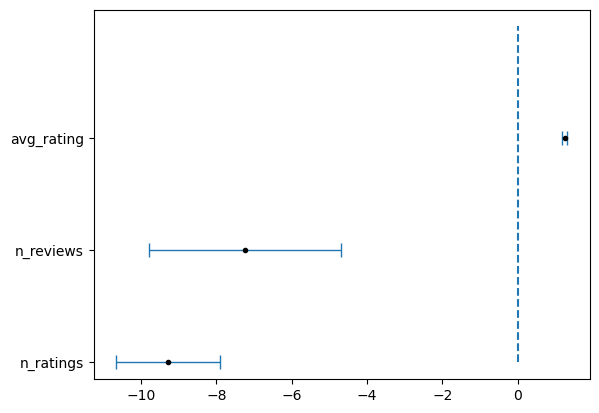

In [16]:
l1, l2, l3, l4 = zip(*sorted(zip(coefficients[1:], variables[1:], standard_errors[1:], p_values[1:])))
plt.errorbar(l1, np.array(range(len(l1))), xerr= 2*np.array(l3), linewidth = 1,
             linestyle = 'none',marker = 'o',markersize= 3,
             markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)

plt.vlines(0,0, len(l1), linestyle = '--')

plt.yticks(range(len(l2)),l2)

## Explorer

In [17]:
# logistic regression using statsmodels
logit_model = smf.logit(formula='is_xpl ~  n_ratings + avg_rating + n_reviews', data=users_ddf)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.393363
         Iterations 6
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.011      
Dependent Variable: is_xpl           AIC:              44936.3877 
Date:               2022-12-22 17:20 BIC:              44972.1985 
No. Observations:   57108            Log-Likelihood:   -22464.    
Df Model:           3                LL-Null:          -22714.    
Df Residuals:       57104            LLR p-value:      4.3702e-108
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
Intercept    -1.8615    0.0123  -151.1277  0.0000  -1.8857  -1.8374
n_ratings     0.0670    0.0134     4.9820  0.0000

## adventurer 

In [18]:
# logistic regression using statsmodels
logit_model = smf.logit(formula='is_adv ~  n_ratings + avg_rating + n_reviews', data=users_ddf)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.232024
         Iterations 8
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.286     
Dependent Variable: is_adv           AIC:              26508.8710
Date:               2022-12-22 17:20 BIC:              26544.6818
No. Observations:   57108            Log-Likelihood:   -13250.   
Df Model:           3                LL-Null:          -18565.   
Df Residuals:       57104            LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     8.0000                                       
------------------------------------------------------------------
             Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept   -3.0607    0.0241  -126.7885  0.0000  -3.1080  -3.0133
n_ratings   -1.0345    0.0662   -15.6172  0.0000  -1.1643  -0.

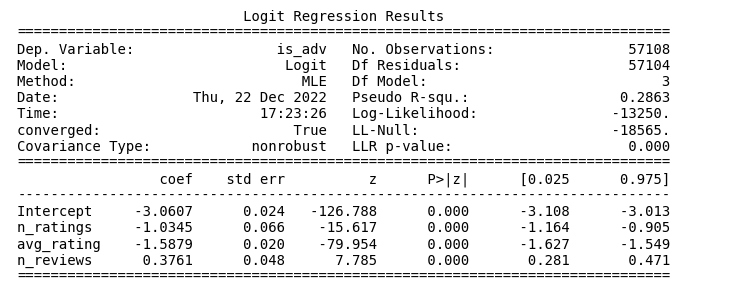

In [25]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(8, 3))
#plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}) old approach
plt.text(0.01, 0.05, str(result.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig('adventurer_regression.svg', dpi=600, transparent=True)